## Imports

In [1]:
import pandas as pd
import glob
import os


# Import data
filename = 'outputs/results/combined_enterprise_output.csv'

df = pd.read_csv(filename)


# Filter only unknown vendors
#print(df['Vendor'])
unknown_vendors = df[df['Vendor'] == 'unknown']
#print(unknown_vendors)
# Group by MAC and count occurrences
mac_counts = unknown_vendors.groupby('Enterprise Code')['IP'].agg(['count', list]).sort_values('count', ascending=False)

# Rename columns for clarity
mac_counts.columns = ['Count', 'IPs']

print(f"Total IPs with unknown vendors: {len(unknown_vendors)}")
print("\nMAC addresses and their counts for unknown vendors:")
print(mac_counts)



# Filter vendors in case we need more filtering 
excluded_vendors_file = "config/excluded_vendors.txt"
with open(excluded_vendors_file, 'r', encoding='utf-8') as file:
    excluded_vendors = {line.strip() for line in file if line.strip()}

# Convert engine time (seconds) to datetime relative to current time
df['Engine_Age'] = pd.Timestamp.now() - pd.to_timedelta(df['Engine Time'], unit='s')
# Filter out rows with engine time before 1998
df = df[df['Engine_Age'].dt.year >= 1998]
print(df['Engine_Age'])

size_before = df.shape[0]
print(excluded_vendors)
df = df[~df["Vendor"].isin(excluded_vendors)]
df = df[df["Vendor"] != 'unknown']
print("Dropped " + str(size_before - df.shape[0]) + " by vendor exclusion.\n" + str(df.shape[0]) + " entries left.")
print(df.columns)

Total IPs with unknown vendors: 1503

MAC addresses and their counts for unknown vendors:
                 Count                                                IPs
Enterprise Code                                                          
1.344692e+09      1240  [62.166.252.1, 62.250.212.1, 62.166.250.1, 87....
3.696296e+08        37  [87.195.120.1, 87.195.100.153, 87.195.100.149,...
9.426822e+08        37  [87.252.207.157, 91.233.23.49, 87.252.207.126,...
1.535348e+09         3         [86.109.13.19, 139.178.72.1, 86.109.13.25]
1.538915e+09         3       [86.109.13.50, 86.109.13.43, 139.178.73.193]
...                ...                                                ...
2.058054e+09         1                                    [147.28.206.10]
2.089420e+09         1                                    [86.109.13.104]
2.104123e+09         1                                    [147.75.86.113]
2.111167e+09         1                                     [86.109.13.99]
2.117797e+09         1

### Popular Vendors:


Vendor Counts:
Vendor
Ambit Microsystems Corporation                                             1407
Thomson Inc.                                                               1008
Arista networks                                                             730
Brocade Communications Systems, Inc.                                        639
H3C                                                                         436
Brocade Communication Systems, Inc. (formerly 'Foundry Networks, Inc.')     348
Fortinet, Inc.                                                              262
Nokia (formerly 'Alcatel-Lucent')                                           251
SonicWALL, Inc.                                                             154
Broadcom Limited                                                             70
Name: count, dtype: int64


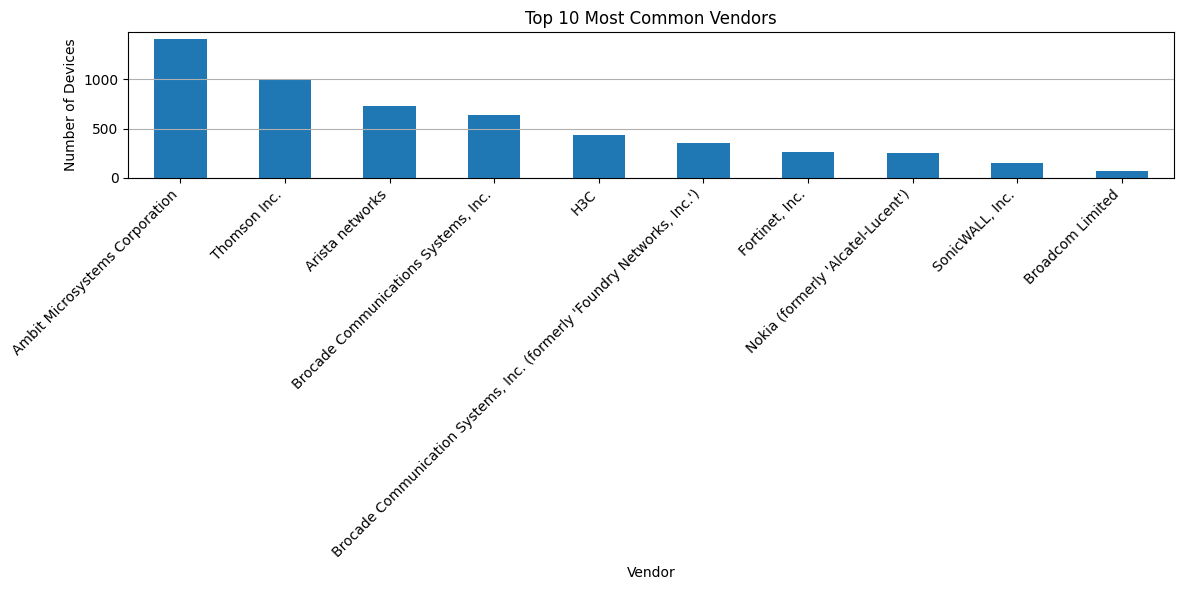

In [2]:
import matplotlib.pyplot as plt

# Get top 10 vendors by count
vendor_counts = df['Vendor'].value_counts().head(10)

# Create bar plot
plt.figure(figsize=(12, 6))
vendor_counts.plot(kind='bar')
plt.title('Top 10 Most Common Vendors')
plt.xlabel('Vendor')
plt.ylabel('Number of Devices')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y')
plt.tight_layout()

# Print exact counts
print("\nVendor Counts:")
print(vendor_counts)

### Fetch CVEs for vendor:

In [3]:
import datetime
from cve_matching import translate_vendor, fetch_CVEs_with_split

# Fetch CVEs for vendor
vendor = 'Arista networks'#NetScreen Technologies, Inc.'#SonicWALL, Inc.'Fortinet, Inc.'
max_engine_time = df[df["Vendor"] == vendor]["Engine Time"].max()
latest_reboot_date = max(df["Reboot Date"], key=lambda x: datetime.datetime.strptime(x, "%m_%d_%Y_%H_%M_%S"))
latest_reboot_datetime = datetime.datetime.strptime(latest_reboot_date, "%m_%d_%Y_%H_%M_%S")
translated_vendor = translate_vendor(vendor)
cves = fetch_CVEs_with_split(translated_vendor, max_engine_time, end_date=latest_reboot_datetime)
print(translated_vendor)
print("Largest Engine Time for", vendor, ":", max_engine_time)
print("Number of CVEs found:", len(cves))

{'cve': {'id': 'CVE-2018-12357', 'sourceIdentifier': 'cve@mitre.org', 'published': '2019-08-15T17:15:11.693', 'lastModified': '2024-11-21T03:45:02.397', 'vulnStatus': 'Modified', 'cveTags': [], 'descriptions': [{'lang': 'en', 'value': 'Arista CloudVision Portal through 2018.1.1 has Incorrect Permissions.'}, {'lang': 'es', 'value': 'Arista CloudVision Portal versiones hasta 2018.1.1, presenta Permisos Incorrectos.'}], 'metrics': {'cvssMetricV30': [{'source': 'nvd@nist.gov', 'type': 'Primary', 'cvssData': {'version': '3.0', 'vectorString': 'CVSS:3.0/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:N/A:N', 'baseScore': 6.5, 'baseSeverity': 'MEDIUM', 'attackVector': 'NETWORK', 'attackComplexity': 'LOW', 'privilegesRequired': 'LOW', 'userInteraction': 'NONE', 'scope': 'UNCHANGED', 'confidentialityImpact': 'HIGH', 'integrityImpact': 'NONE', 'availabilityImpact': 'NONE'}, 'exploitabilityScore': 2.8, 'impactScore': 3.6}], 'cvssMetricV2': [{'source': 'nvd@nist.gov', 'type': 'Primary', 'cvssData': {'version': '2.0

### Vulnerable IPs over time:

/tmp/ipykernel_293037/1775842249.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Reboot_Datetime'] = pd.to_datetime(df_filtered['Reboot Date'], format='%m_%d_%Y_%H_%M_%S')


2019-04-15 22:22:03


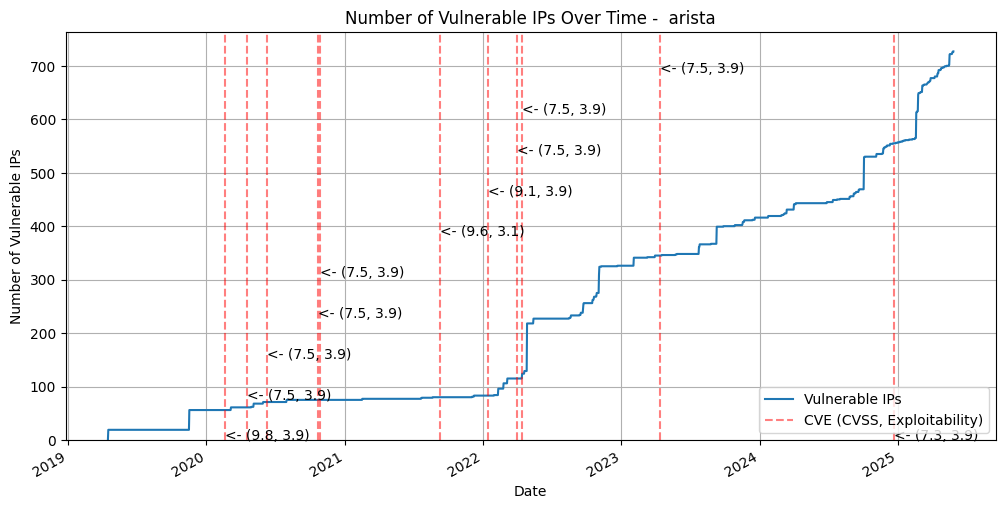

In [7]:
import matplotlib.pyplot as plt

# Convert reboot dates to datetime
# Filter dataframe for specified vendor
df_filtered = df[df['Vendor'] == vendor]
df_filtered['Reboot_Datetime'] = pd.to_datetime(df_filtered['Reboot Date'], format='%m_%d_%Y_%H_%M_%S')
df_filtered = df_filtered[df_filtered['Reboot_Datetime'].dt.year >= 1998]

# Create time series of vulnerability counts
print(df_filtered['Reboot_Datetime'].min())
time_range = pd.date_range(start=df_filtered['Reboot_Datetime'].min(), end=df_filtered['Reboot_Datetime'].max(), freq='D')
vulnerable_counts = []

for time_point in time_range:
    # Count IPs with reboot time older than this date (vulnerable)
    vulnerable_ips = df_filtered[df_filtered['Reboot_Datetime'] <= time_point]['IP'].nunique()
    vulnerable_counts.append(vulnerable_ips)

# Create and plot the time series
vulnerability_ts = pd.Series(vulnerable_counts, index=time_range)
vulnerability_ts.plot(figsize=(12, 6))
plt.title(f'Number of Vulnerable IPs Over Time - {translated_vendor}')
plt.xlabel('Date')
plt.ylabel('Number of Vulnerable IPs')
plt.grid(True)
plt.ylim(bottom=0)  # Force y-axis to start at 0

start_date = df_filtered['Reboot_Datetime'].min()
end_date = df_filtered['Reboot_Datetime'].max()

for _, cve in cves.iterrows():
    cve_id = cve['CVE_ID']
    published_str = cve['Published']
    cve_date = pd.to_datetime(published_str).normalize()

# Create a dictionary to store highest scoring CVE per date
cve_highest_scores = {}
for _, cve in cves.iterrows():
    cve_date = pd.to_datetime(cve['Published']).normalize()
    if cve['CVSS_Score'] > 7 and cve['Exploitablity_Score'] > 3:
        if cve_date >= start_date and cve_date <= end_date:
            current_score = cve['CVSS_Score'] + cve['Exploitablity_Score']
            if cve_date not in cve_highest_scores or current_score > cve_highest_scores[cve_date]['score']:
                cve_highest_scores[cve_date] = {
                    'score': current_score,
                    'cvss': cve['CVSS_Score'],
                    'exploitability': cve['Exploitablity_Score']
                }

# Plot the highest scoring CVE per date
i = 0
for cve_date, scores in cve_highest_scores.items():
    plt.axvline(x=cve_date, color='r', linestyle='--', alpha=0.5)
    text_height = plt.ylim()[0] + (plt.ylim()[1] - plt.ylim()[0]) * (0.1 * (i % 10))
    plt.text(cve_date, text_height, f'<- ({scores["cvss"]:.1f}, {scores["exploitability"]:.1f})', 
             horizontalalignment='left', alpha=1)
    i += 1
plt.legend(['Vulnerable IPs', 'CVE (CVSS, Exploitability)'])

/tmp/ipykernel_293037/2407310557.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top10['Scan Date'] = pd.to_datetime(df_top10['Scan Date'], format='%m_%d_%H_%M_%S')
/tmp/ipykernel_293037/2407310557.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top10['Reboot Date'] = pd.to_datetime(df_top10['Reboot Date'], format='%m_%d_%Y_%H_%M_%S')
/tmp/ipykernel_293037/2407310557.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

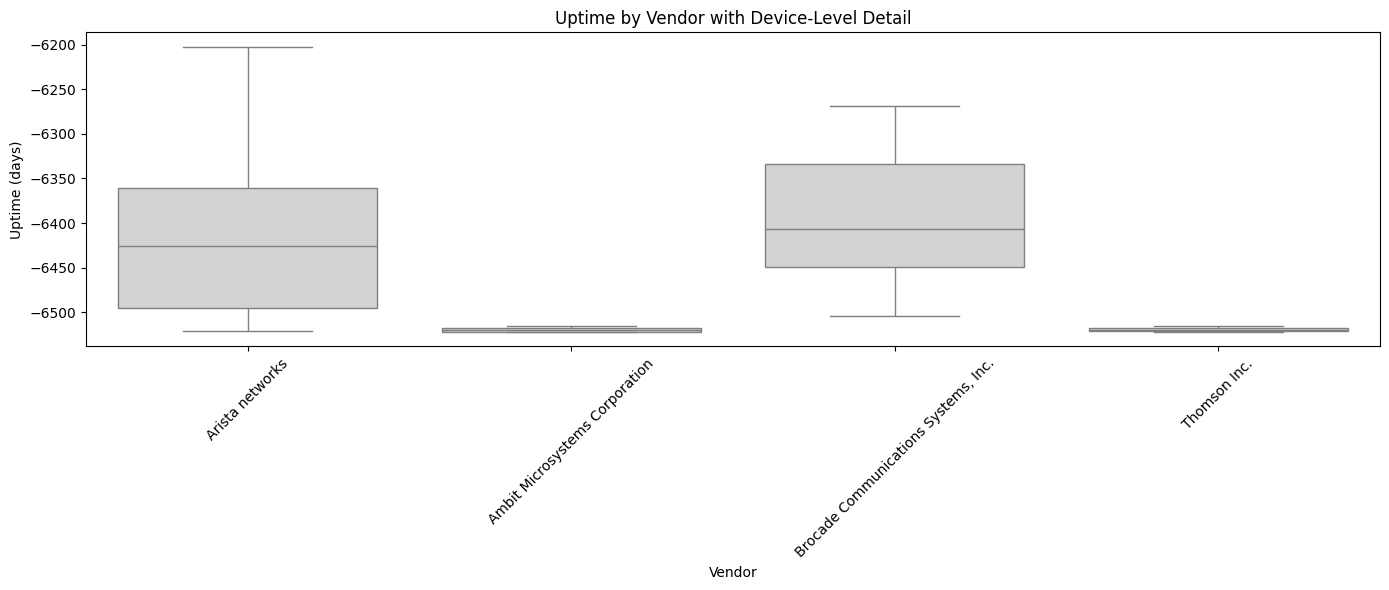

Empty DataFrame
Columns: [CVE_ID, Description, Published, CVSS_Score, Severity, CVSS_Version, Exploitablity_Score]
Index: []


In [5]:
import seaborn as sns
# Get top 10 vendors by count
top_10_vendors = df['Vendor'].value_counts().head(4).index
df_top10 = df[df['Vendor'].isin(top_10_vendors)]

df_top10['Scan Date'] = pd.to_datetime(df_top10['Scan Date'], format='%m_%d_%H_%M_%S')

df_top10['Reboot Date'] = pd.to_datetime(df_top10['Reboot Date'], format='%m_%d_%Y_%H_%M_%S')
df_top10['Uptime_Days'] = (df_top10['Scan Date'] - df_top10['Reboot Date']).dt.days / 7
# Convert Reboot Date to datetime for better handling
plt.figure(figsize=(14, 6))
sns.boxplot(x='Vendor', y='Uptime_Days', data=df_top10, color='lightgray', showfliers=False)
#sns.swarmplot(x='Vendor', y='Uptime_Days', data=df_top10, size=4, alpha=0.6)
plt.xticks(rotation=45)
plt.title('Uptime by Vendor with Device-Level Detail')
plt.ylabel('Uptime (days)')
plt.xlabel('Vendor')
plt.tight_layout()
plt.show()
# Calculate uptime in weeks

print(cves.head(0))

### Average engine time per vendor:

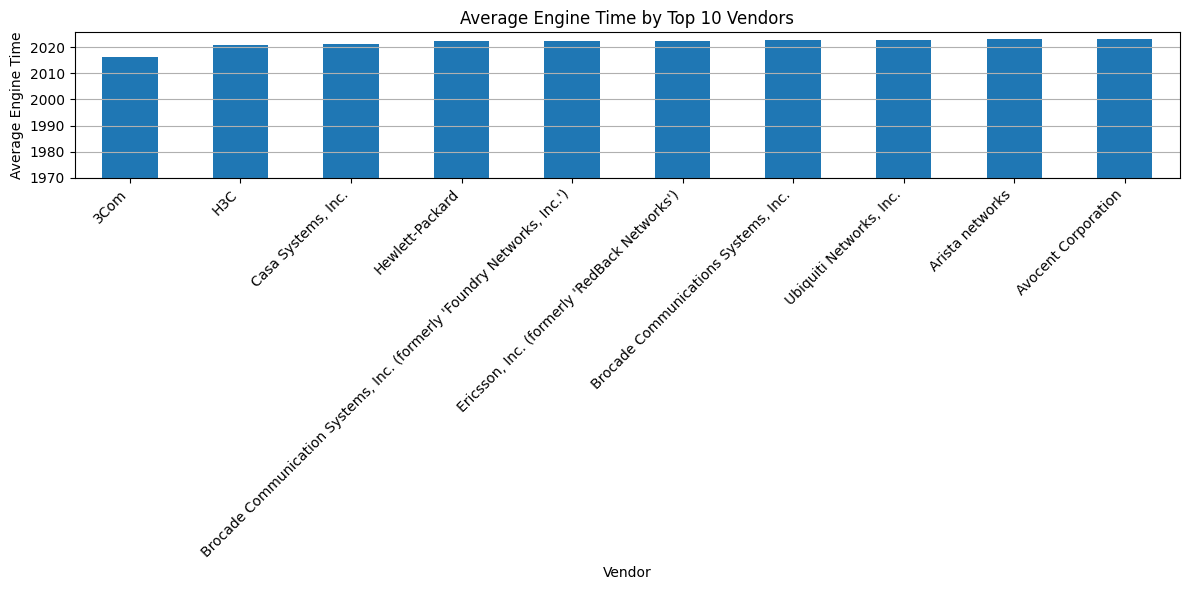

In [6]:
# Calculate average engine time per vendor
avg_engine_time = df.groupby('Vendor')['Engine Time'].mean().sort_values(ascending=False).head(10)
avg_engine_time = avg_engine_time / (7 * 24 * 60 * 60)  # Convert to weeks
# Create bar plot
# Convert seconds to datetime based on latest reboot date
latest_date = pd.to_datetime(df['Reboot Date'].max(), format='%m_%d_%Y_%H_%M_%S')
avg_engine_age = latest_date - pd.to_timedelta(df.groupby('Vendor')['Engine Time'].mean(), unit='s')
avg_engine_age = avg_engine_age.sort_values(ascending=True).head(10)
plt.figure(figsize=(12, 6))
avg_engine_age.plot(kind='bar')
plt.title('Average Engine Time by Top 10 Vendors')
plt.xlabel('Vendor')
plt.ylabel('Average Engine Time')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
# Convert engine time to weeks for better readability

plt.grid(True, axis='y')